In [231]:
import pandas as pd 
import os
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

**SECTION 1 : Understand the dataset.** 

1. LOAD 'CoffeeShop.xlsx'
    - import using 'pandas'

In [110]:
CoffeeShop = pd.read_excel(r"C:\Users\NAJWA FAZLINI\Downloads\CoffeeShop.xlsx")
CoffeeShop

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.00,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.10,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.50,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.00,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.10,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
...,...,...,...,...,...,...,...,...,...,...,...
149111,149452,2023-06-30,20:18:41,2,8,Hell's Kitchen,44,2.50,Tea,Brewed herbal tea,Peppermint Rg
149112,149453,2023-06-30,20:25:10,2,8,Hell's Kitchen,49,3.00,Tea,Brewed Black tea,English Breakfast Lg
149113,149454,2023-06-30,20:31:34,1,8,Hell's Kitchen,45,3.00,Tea,Brewed herbal tea,Peppermint Lg
149114,149455,2023-06-30,20:57:19,1,8,Hell's Kitchen,40,3.75,Coffee,Barista Espresso,Cappuccino


From the CoffeeShop , we can get the initial idea where the dataset contain 149116 rows and 11 columns. Let's move on to next steps.

2. DATA CLEANING
   - identify missing values and duplicate rows
   - remove unrelevant data

In [112]:
#1. Identiy missing number
MissingNo  = CoffeeShop.isna().sum()
MissingNo

transaction_id      0
transaction_date    0
transaction_time    0
transaction_qty     0
store_id            0
store_location      0
product_id          0
unit_price          0
product_category    0
product_type        0
product_detail      0
dtype: int64

As we can see here, no missing values are present in each column of CoffeeShop.

In [114]:
#2. Identify duplicate rows 
DuplicateRows = CoffeeShop.duplicated().sum()
DuplicateRows

0

The '0' indicates the CoffeeShop has no duplicate rows. 

**SECTION 2 : DATA PROCESSING**

In [116]:
DataType = CoffeeShop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   transaction_id    149116 non-null  int64         
 1   transaction_date  149116 non-null  datetime64[ns]
 2   transaction_time  149116 non-null  object        
 3   transaction_qty   149116 non-null  int64         
 4   store_id          149116 non-null  int64         
 5   store_location    149116 non-null  object        
 6   product_id        149116 non-null  int64         
 7   unit_price        149116 non-null  float64       
 8   product_category  149116 non-null  object        
 9   product_type      149116 non-null  object        
 10  product_detail    149116 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 12.5+ MB


In [119]:
# add month to new column from transaction_date

#Ensure the transaction_time is in datetime format
CoffeeShop['transaction_date'] = pd.to_datetime(CoffeeShop['transaction_date'])

# extract the month and add to new column
CoffeeShop['month'] = CoffeeShop['transaction_date'].dt.month
CoffeeShop['month']

0         1
1         1
2         1
3         1
4         1
         ..
149111    6
149112    6
149113    6
149114    6
149115    6
Name: month, Length: 149116, dtype: int32

In [121]:
# add day of month from transaction_date

#Ensure the transaction_time is in datetime format
CoffeeShop['transaction_date'] = pd.to_datetime(CoffeeShop['transaction_date'])

# extract the month and add to new column
CoffeeShop['day_of_month'] = CoffeeShop['transaction_date'].dt.day
CoffeeShop['day_of_month']

0          1
1          1
2          1
3          1
4          1
          ..
149111    30
149112    30
149113    30
149114    30
149115    30
Name: day_of_month, Length: 149116, dtype: int32

In [123]:
# Function to convert time strings to datetime.time objects
def convert_time(t):
    if isinstance(t, str):  # Check if it's a string
        try:
            return datetime.strptime(t, '%I:%M:%S %p').time()  # Try to parse with AM/PM format
        except ValueError:
            return datetime.strptime(t, '%H:%M:%S').time()  # Fall back to 24-hour format
    return t  # Already a datetime.time object

# Apply the conversion function
CoffeeShop['transaction_time'] = CoffeeShop['transaction_time'].apply(convert_time)
CoffeeShop['transaction_time']

0         07:06:11
1         07:08:56
2         07:14:04
3         07:20:24
4         07:22:41
            ...   
149111    20:18:41
149112    20:25:10
149113    20:31:34
149114    20:57:19
149115    20:57:19
Name: transaction_time, Length: 149116, dtype: object

In [125]:
# Categorize transaction time into morning, afternoon, evening and night 
# Function to categorize time
def categorize_time(t):
    if 6 <= t.hour < 12:
        return 'Morning'
    elif 12 <= t.hour < 17:
        return 'Afternoon'
    elif 17 <= t.hour < 19:
        return 'Evening'
    else:
        return 'Night'

# Apply categorization
CoffeeShop['day_hour'] = CoffeeShop['transaction_time'].apply(categorize_time)
CoffeeShop['day_hour']

0         Morning
1         Morning
2         Morning
3         Morning
4         Morning
           ...   
149111      Night
149112      Night
149113      Night
149114      Night
149115      Night
Name: day_hour, Length: 149116, dtype: object

**SECTION 3: EXPLORATORY DATA ANALYSIS (EDA)**
- To analyze the CoffeeShop and turn the dataset into meaningful insights using visualizations.
- The dataset consist of three store which are **Lower Manhattan, Hell's Kitchen and Astoria**

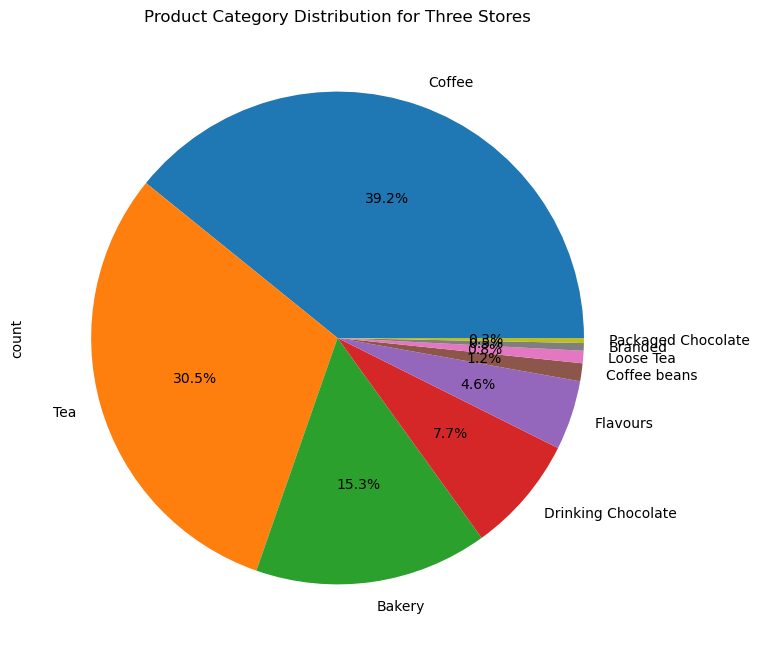

In [127]:
# Plot pie chart to see the distribution for product category
ProductCategory = CoffeeShop ['product_category'].value_counts()
plt.figure(figsize =(8,8))
ProductCategory.plot.pie(autopct ='%1.1f%%',legend=False )
plt.title('Product Category Distribution for Three Stores')
plt.show()

From Product Category distribution, **coffee**,**tea**,**bakery** are the bestsellers among three stores.

In [130]:
# create table for sum of transaction quantity with product category
Quantity = CoffeeShop.groupby('product_category')['transaction_qty'].sum().reset_index()
Quantity = Quantity.sort_values(by='transaction_qty', ascending=False)
Quantity

,product_category,transaction_qty
2,Coffee,89250
8,Tea,69737
0,Bakery,23214
4,Drinking Chocolate,17457
5,Flavours,10511
3,Coffee beans,1828
6,Loose Tea,1210
1,Branded,776
7,Packaged Chocolate,487


In [132]:
# create pivot table for product category and month
PivotTableA = CoffeeShop.pivot_table(
    index = 'product_category',
    columns = 'month',
    values = 'transaction_qty',
    aggfunc = 'sum',
    fill_value = 0
)

PivotTableA['Total'] = PivotTableA.sum(axis=1)
PivotTableA = PivotTableA.sort_values(by="Total", ascending=False)
PivotTableA

month,1,2,3,4,5,6,Total
product_category,,,,,,,
Coffee,10355,9689,12604,15210,19948,21444,89250
Tea,8060,7718,9906,11839,15813,16401,69737
Bakery,2690,2559,3358,3951,5225,5431,23214
Drinking Chocolate,2015,1964,2475,2952,3930,4121,17457
Flavours,1218,1163,1465,1773,2382,2510,10511
Coffee beans,234,195,251,310,407,431,1828
Loose Tea,141,137,178,197,259,298,1210
Branded,100,74,104,142,161,195,776
Packaged Chocolate,57,51,65,95,108,111,487


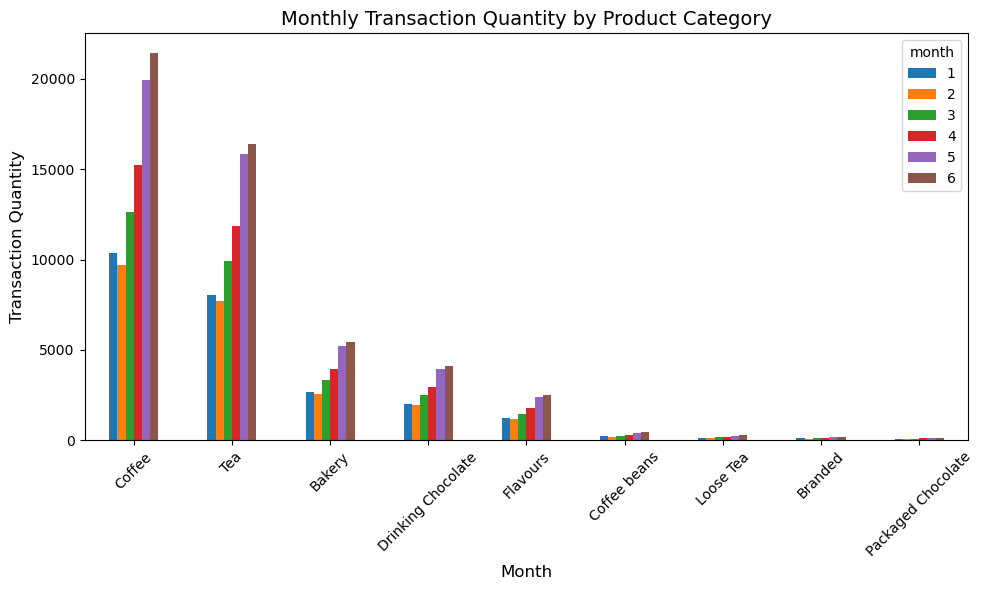

In [134]:
# Plot each product category by month
plot_data = PivotTableA.drop(columns=["Total"])

plot_data.plot(kind="bar", figsize=(10, 6))
plt.title("Monthly Transaction Quantity by Product Category", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Transaction Quantity", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="month", fontsize=10)
plt.tight_layout()
plt.show()

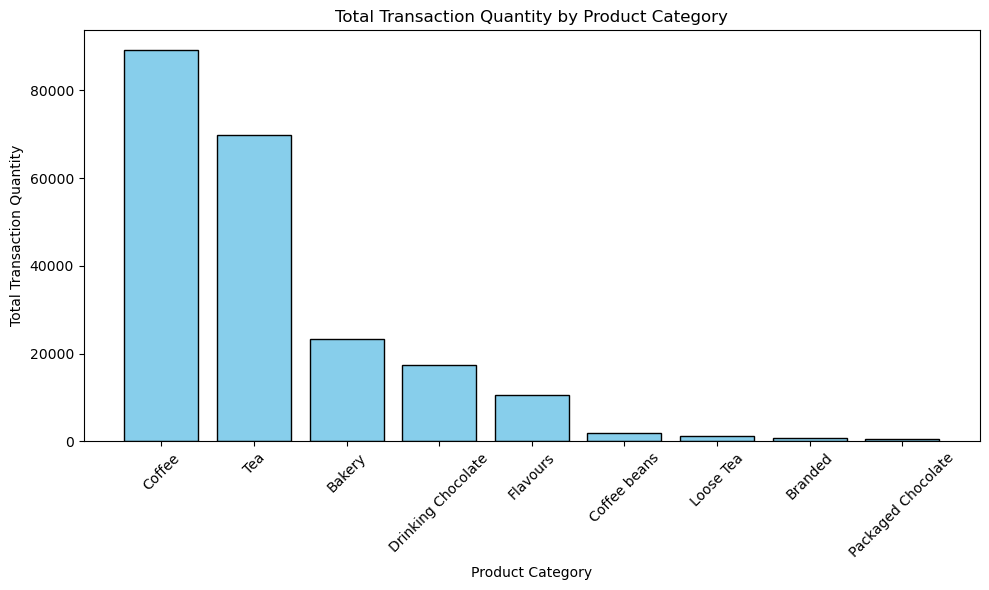

In [136]:
# Plot the bar graph for Quantity 
plt.figure(figsize=(10, 6))
plt.bar(Quantity['product_category'], Quantity['transaction_qty'], color='skyblue',edgecolor='black')
plt.xlabel('Product Category')
plt.ylabel('Total Transaction Quantity')
plt.title('Total Transaction Quantity by Product Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [138]:
# create pivot table for product category and day_hour by transaction qty
PivotTable = CoffeeShop.pivot_table(
    index = 'product_category',
    columns = 'day_hour',
    values = 'transaction_qty',
    aggfunc = 'sum',
    fill_value = 0
)

PivotTable['Total'] = PivotTable.sum(axis=1)
PivotTable = PivotTable.sort_values(by="Total", ascending=False)
PivotTable

day_hour,Afternoon,Evening,Morning,Night,Total
product_category,,,,,
Coffee,27549,10236,47643,3822,89250
Tea,21379,7940,37153,3265,69737
Bakery,6436,2278,13561,939,23214
Drinking Chocolate,5375,1970,9184,928,17457
Flavours,2170,786,7221,334,10511
Coffee beans,373,120,1258,77,1828
Loose Tea,262,98,797,53,1210
Branded,190,62,490,34,776
Packaged Chocolate,106,36,322,23,487


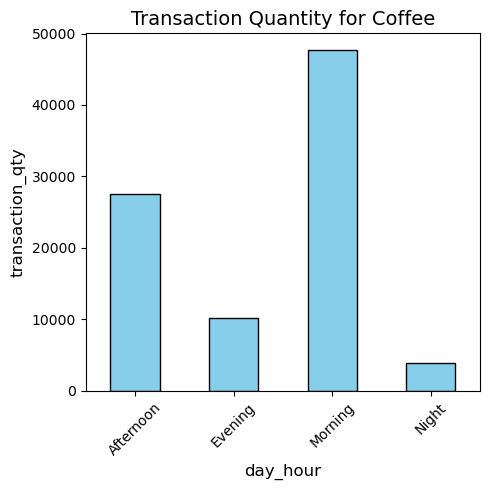

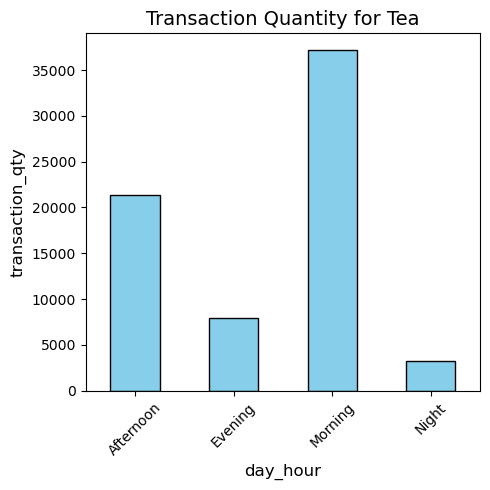

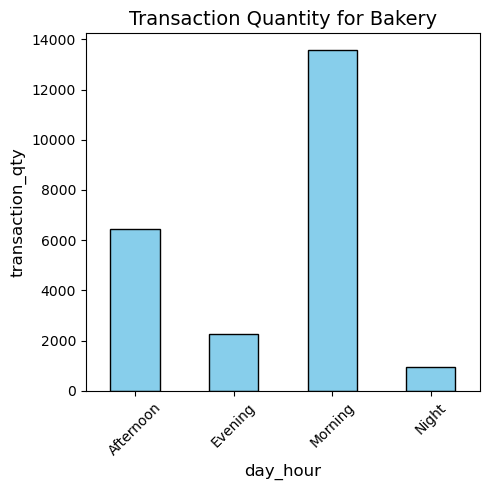

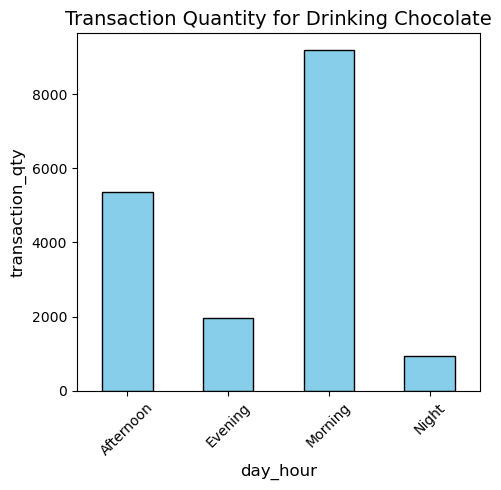

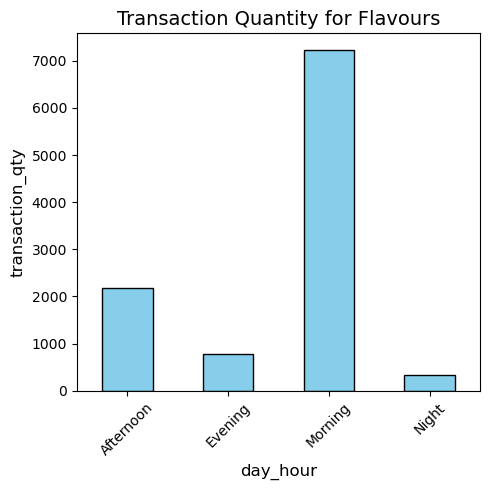

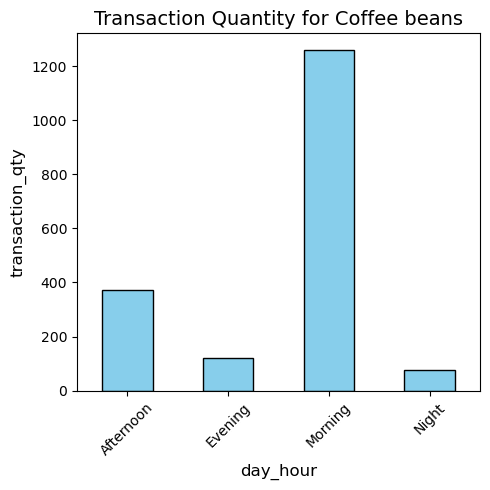

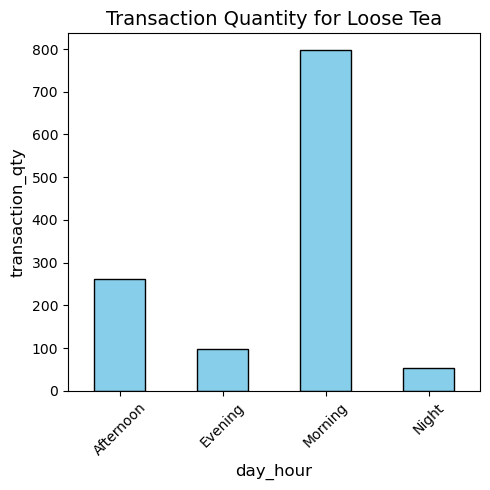

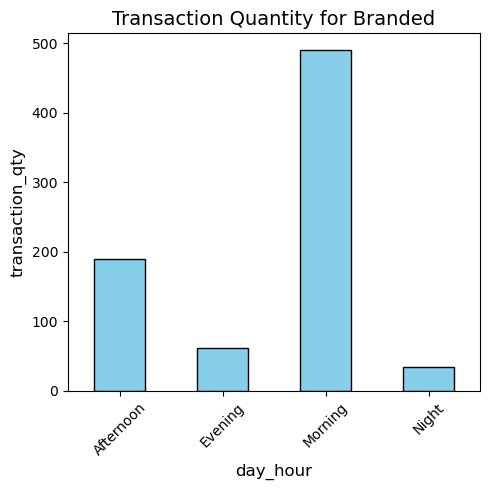

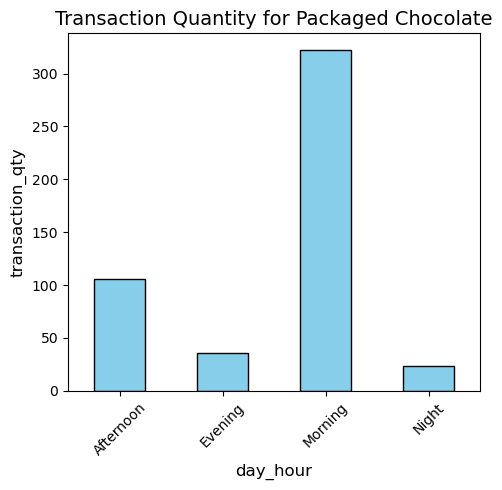

In [140]:
# Plot bar graph for each product category by day_hour
# Drop the 'Total' column for plotting
plot_data = PivotTable.drop(columns=["Total"])

# Plot for each product category
for product_category in plot_data.index:
    plt.figure(figsize=(5, 5))
    plot_data.loc[product_category].plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Transaction Quantity for {product_category}", fontsize=14)
    plt.xlabel("day_hour", fontsize=12)
    plt.ylabel("transaction_qty", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()

**Further analysis based on store location**
- To gain more valuable insighs on different product category, mean unit price, product type and product detail.

1. Lower Manhattan

In [168]:
StoreLocation1 = CoffeeShop[CoffeeShop['store_location'] == 'Lower Manhattan']
StoreLocation1

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,month,day_of_month,day_hour
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.00,Coffee,Gourmet brewed coffee,Ethiopia Rg,1,1,Morning
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.10,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,1,1,Morning
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.50,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,1,1,Morning
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.00,Coffee,Drip coffee,Our Old Time Diner Blend Sm,1,1,Morning
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.10,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,1,1,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149045,149386,2023-06-30,18:28:56,2,5,Lower Manhattan,22,2.00,Coffee,Drip coffee,Our Old Time Diner Blend Sm,6,30,Evening
149046,149387,2023-06-30,18:30:02,1,5,Lower Manhattan,59,4.50,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,6,30,Evening
149047,149388,2023-06-30,18:30:02,1,5,Lower Manhattan,72,3.25,Bakery,Scone,Ginger Scone,6,30,Evening
149094,149435,2023-06-30,19:40:09,2,5,Lower Manhattan,58,3.50,Drinking Chocolate,Hot chocolate,Dark chocolate Rg,6,30,Night


In [174]:
# create pivot table for unit price for each product category at Lower Manhattan
PivotTableB = StoreLocation1.pivot_table(
    index = 'product_category',
    values = 'unit_price',
    aggfunc = 'mean'
)
PivotTableB

,unit_price
product_category,
Bakery,3.540106
Branded,16.727794
Coffee,3.031622
Coffee beans,20.981073
Drinking Chocolate,4.141850
Flavours,0.800000
Loose Tea,9.339239
Packaged Chocolate,8.995333
Tea,2.813578


Repeat the steps for **Hell's Kitchen** and **Astoria**

2. Hell's Kitchen

In [181]:
StoreLocation2 = CoffeeShop[CoffeeShop['store_location'] == "Hell's Kitchen"]
StoreLocation2

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,month,day_of_month,day_hour
17,18,2023-01-01,08:00:18,1,8,Hell's Kitchen,42,2.50,Tea,Brewed herbal tea,Lemon Grass Rg,1,1,Morning
18,19,2023-01-01,08:00:39,2,8,Hell's Kitchen,59,4.50,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,1,1,Morning
19,20,2023-01-01,08:11:45,1,8,Hell's Kitchen,61,4.75,Drinking Chocolate,Hot chocolate,Sustainably Grown Organic Lg,1,1,Morning
20,21,2023-01-01,08:17:27,2,8,Hell's Kitchen,33,3.50,Coffee,Gourmet brewed coffee,Ethiopia Lg,1,1,Morning
23,24,2023-01-01,08:29:38,1,8,Hell's Kitchen,56,2.55,Tea,Brewed Chai tea,Spicy Eye Opener Chai Rg,1,1,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149111,149452,2023-06-30,20:18:41,2,8,Hell's Kitchen,44,2.50,Tea,Brewed herbal tea,Peppermint Rg,6,30,Night
149112,149453,2023-06-30,20:25:10,2,8,Hell's Kitchen,49,3.00,Tea,Brewed Black tea,English Breakfast Lg,6,30,Night
149113,149454,2023-06-30,20:31:34,1,8,Hell's Kitchen,45,3.00,Tea,Brewed herbal tea,Peppermint Lg,6,30,Night
149114,149455,2023-06-30,20:57:19,1,8,Hell's Kitchen,40,3.75,Coffee,Barista Espresso,Cappuccino,6,30,Night


In [188]:
PivotTableC = StoreLocation2.pivot_table(
    index = 'product_category',
    values = 'unit_price',
    aggfunc = 'mean'
)
PivotTableC

,unit_price
product_category,
Bakery,3.569378
Branded,16.319328
Coffee,3.015869
Coffee beans,21.507083
Drinking Chocolate,4.159713
Flavours,0.800000
Loose Tea,9.198660
Packaged Chocolate,8.623198
Tea,2.814699


3. Astoria

In [192]:
StoreLocation3 = CoffeeShop[CoffeeShop['store_location'] == 'Astoria']
StoreLocation3

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,month,day_of_month,day_hour
105,106,2023-01-01,11:01:48,1,3,Astoria,22,2.00,Coffee,Drip coffee,Our Old Time Diner Blend Sm,1,1,Morning
106,107,2023-01-01,11:01:58,1,3,Astoria,38,3.75,Coffee,Barista Espresso,Latte,1,1,Morning
107,108,2023-01-01,11:01:58,1,3,Astoria,75,3.50,Bakery,Pastry,Croissant,1,1,Morning
111,112,2023-01-01,11:08:11,1,3,Astoria,59,4.50,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,1,1,Morning
113,114,2023-01-01,11:09:01,1,3,Astoria,59,4.50,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,1,1,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149103,149444,2023-06-30,19:51:59,2,3,Astoria,26,3.00,Coffee,Organic brewed coffee,Brazilian Rg,6,30,Night
149104,149445,2023-06-30,19:52:28,2,3,Astoria,34,2.45,Coffee,Premium brewed coffee,Jamaican Coffee River Sm,6,30,Night
149105,149446,2023-06-30,19:53:46,1,3,Astoria,24,3.00,Coffee,Drip coffee,Our Old Time Diner Blend Lg,6,30,Night
149107,149448,2023-06-30,19:57:49,2,3,Astoria,54,2.50,Tea,Brewed Chai tea,Morning Sunrise Chai Rg,6,30,Night


In [194]:
PivotTableD = StoreLocation3.pivot_table(
    index = 'product_category',
    values = 'unit_price',
    aggfunc = 'mean'
)
PivotTableD

,unit_price
product_category,
Bakery,3.545720
Branded,19.559140
Coffee,3.024235
Coffee beans,20.356972
Drinking Chocolate,4.144826
Flavours,0.800000
Loose Tea,9.284884
Packaged Chocolate,9.906455
Tea,2.822429


**SECTION 4 : Bag of N-grams**
- To transforms collection of text into numerical data. This method is commonly used in Natural Language processing (NLP).

In [211]:
ProductType = CoffeeShop['product_type']
ProductType

0         Gourmet brewed coffee
1               Brewed Chai tea
2                 Hot chocolate
3                   Drip coffee
4               Brewed Chai tea
                  ...          
149111        Brewed herbal tea
149112         Brewed Black tea
149113        Brewed herbal tea
149114         Barista Espresso
149115            Regular syrup
Name: product_type, Length: 149116, dtype: object

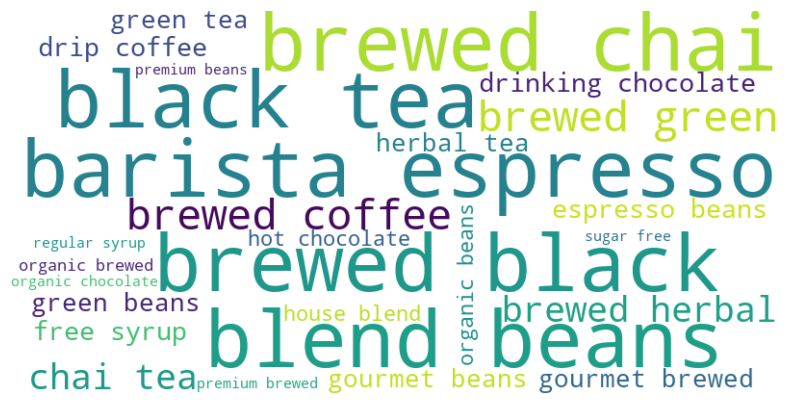

In [235]:
vectorizer = CountVectorizer(ngram_range=(2, 2))
X = vectorizer.fit_transform(ProductType)
bigrams = vectorizer.get_feature_names_out()
bigram_freq = Counter(bigrams)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [237]:
ProductCategory = CoffeeShop['product_category']
ProductCategory

0                     Coffee
1                        Tea
2         Drinking Chocolate
3                     Coffee
4                        Tea
                 ...        
149111                   Tea
149112                   Tea
149113                   Tea
149114                Coffee
149115              Flavours
Name: product_category, Length: 149116, dtype: object

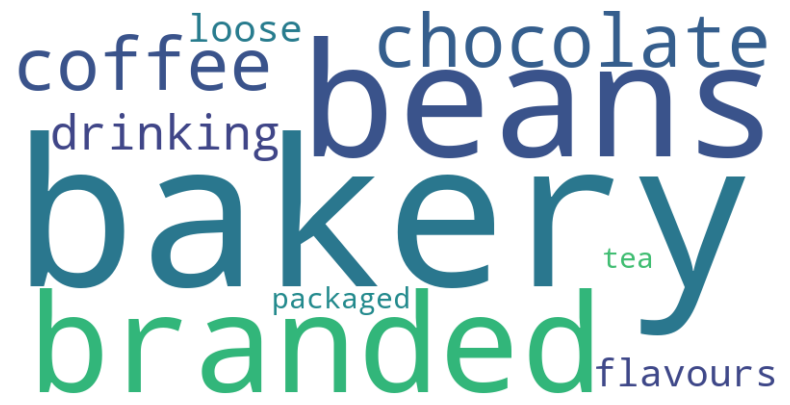

In [245]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
X = vectorizer.fit_transform(ProductCategory)
bigrams = vectorizer.get_feature_names_out()
bigram_freq = Counter(bigrams)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [247]:
ProductDetail = CoffeeShop['product_detail']
ProductDetail

0                         Ethiopia Rg
1            Spicy Eye Opener Chai Lg
2                   Dark chocolate Lg
3         Our Old Time Diner Blend Sm
4            Spicy Eye Opener Chai Lg
                     ...             
149111                  Peppermint Rg
149112           English Breakfast Lg
149113                  Peppermint Lg
149114                     Cappuccino
149115                 Hazelnut syrup
Name: product_detail, Length: 149116, dtype: object

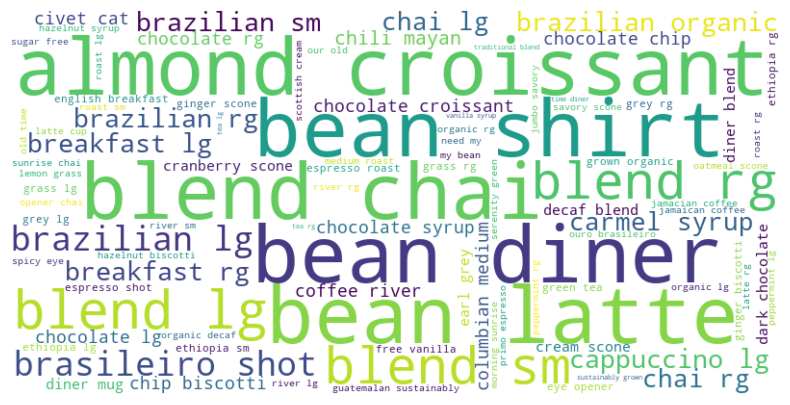

In [249]:
vectorizer = CountVectorizer(ngram_range=(2, 2))
X = vectorizer.fit_transform(ProductDetail)
bigrams = vectorizer.get_feature_names_out()
bigram_freq = Counter(bigrams)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Latest CoffeeShop Dataset**
- 3 feaures were added which are month,day of_month and day_hour.

In [254]:
CoffeeShop

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,month,day_of_month,day_hour
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.00,Coffee,Gourmet brewed coffee,Ethiopia Rg,1,1,Morning
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.10,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,1,1,Morning
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.50,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,1,1,Morning
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.00,Coffee,Drip coffee,Our Old Time Diner Blend Sm,1,1,Morning
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.10,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,1,1,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149111,149452,2023-06-30,20:18:41,2,8,Hell's Kitchen,44,2.50,Tea,Brewed herbal tea,Peppermint Rg,6,30,Night
149112,149453,2023-06-30,20:25:10,2,8,Hell's Kitchen,49,3.00,Tea,Brewed Black tea,English Breakfast Lg,6,30,Night
149113,149454,2023-06-30,20:31:34,1,8,Hell's Kitchen,45,3.00,Tea,Brewed herbal tea,Peppermint Lg,6,30,Night
149114,149455,2023-06-30,20:57:19,1,8,Hell's Kitchen,40,3.75,Coffee,Barista Espresso,Cappuccino,6,30,Night
